<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122002 entries, 0 to 122001
Data columns (total 16 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   WEEK                         122002 non-null  object 
 1   ITEM_CODE                    122002 non-null  object 
 2   TOTAL_UNIT_SALES             122002 non-null  float64
 3   TOTAL_VALUE_SALES            122002 non-null  float64
 4   TOTAL_UNIT_AVG_WEEKLY_SALES  122002 non-null  float64
 5   REGION                       122002 non-null  object 
 6   MANUFACTURER                 122002 non-null  object 
 7   BRAND                        122002 non-null  object 
 8   ITEM                         122002 non-null  object 
 9   ITEM_DESCRIPTION             122002 non-null  object 
 10  CATEGORY                     122002 non-null  int64  
 11  FORMAT                       122002 non-null  object 
 12  ATTR1                        122002 non-null  object 
 13 

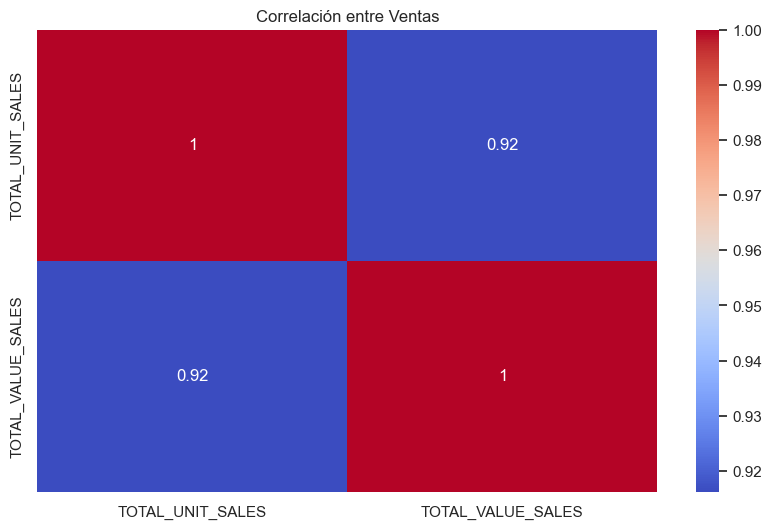

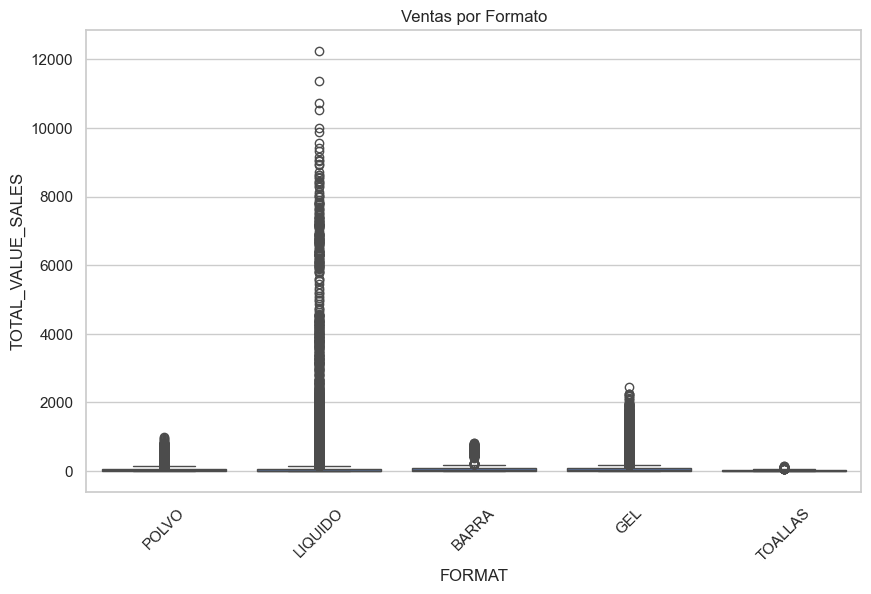

'# 🔍 Correlación entre variables de ventas\ncorrelation = df[["TOTAL_UNIT_SALES", "TOTAL_VALUE_SALES"]].corr()\nsns.heatmap(correlation, annot=True, cmap="coolwarm")\nplt.title("Correlación entre Ventas")\n#plt.savefig("correlacion_ventas.png")\nplt.show()'

In [9]:
#Importar librerías
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Configuración de estilo
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

#Cargar archivo
df = pd.read_csv("tabla_consolidada_final.csv")

#Vista general de los datos
print(df.info())
print(df.describe())
print(df.head())

#Correlación entre variables de ventas
correlation = df[["TOTAL_UNIT_SALES", "TOTAL_VALUE_SALES"]].corr()
sns.heatmap(correlation, annot=True, cmap="coolwarm")
plt.title("Correlación entre Ventas")
plt.savefig("correlacion_ventas.png")
plt.show()

#Distribución de ventas
sns.boxplot(x="FORMAT", y="TOTAL_VALUE_SALES", data=df)
plt.title("Ventas por Formato")
plt.xticks(rotation=45)
plt.savefig("boxplot_formato.png")
plt.show()

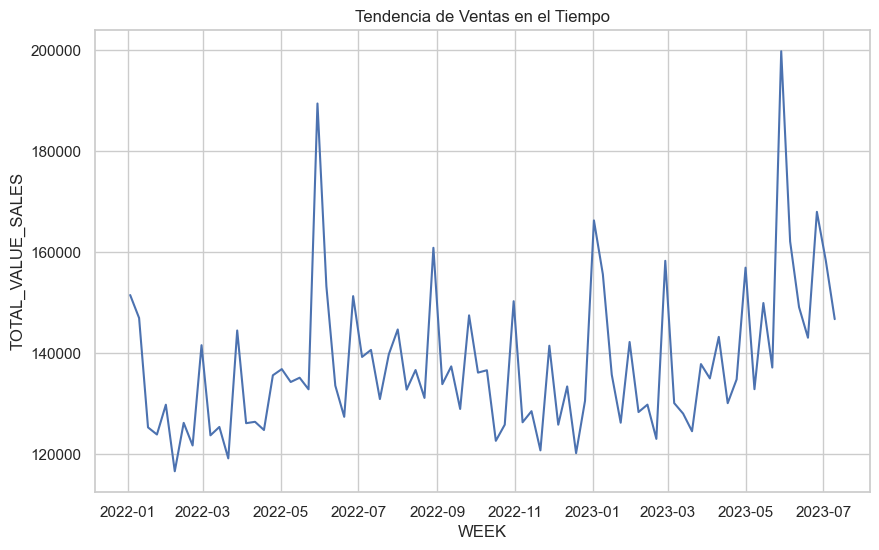

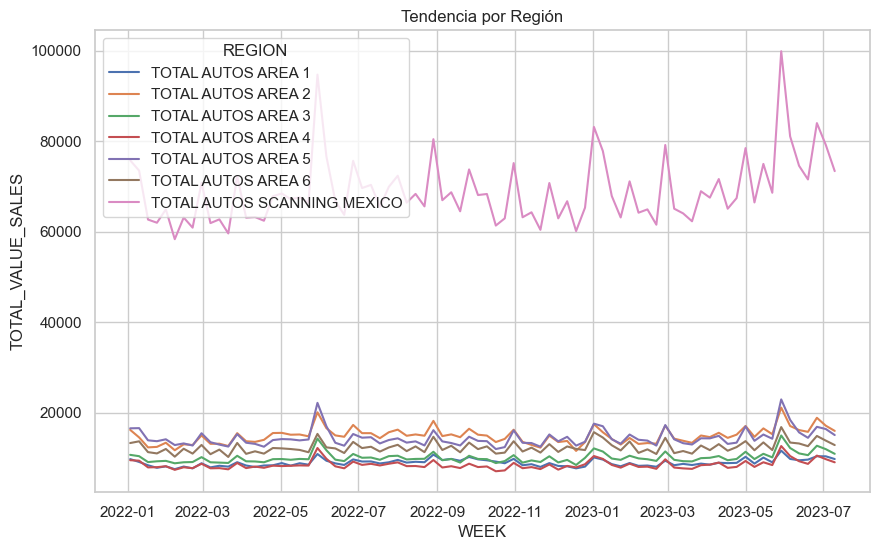

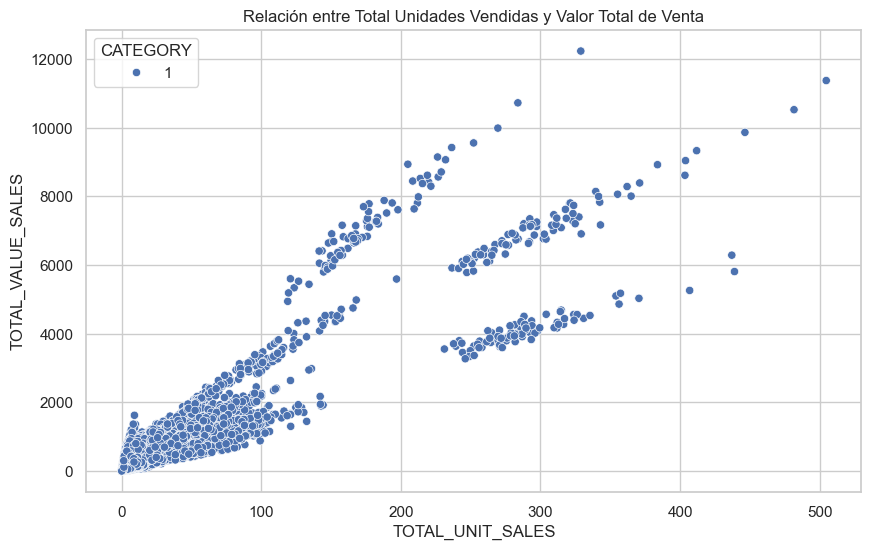

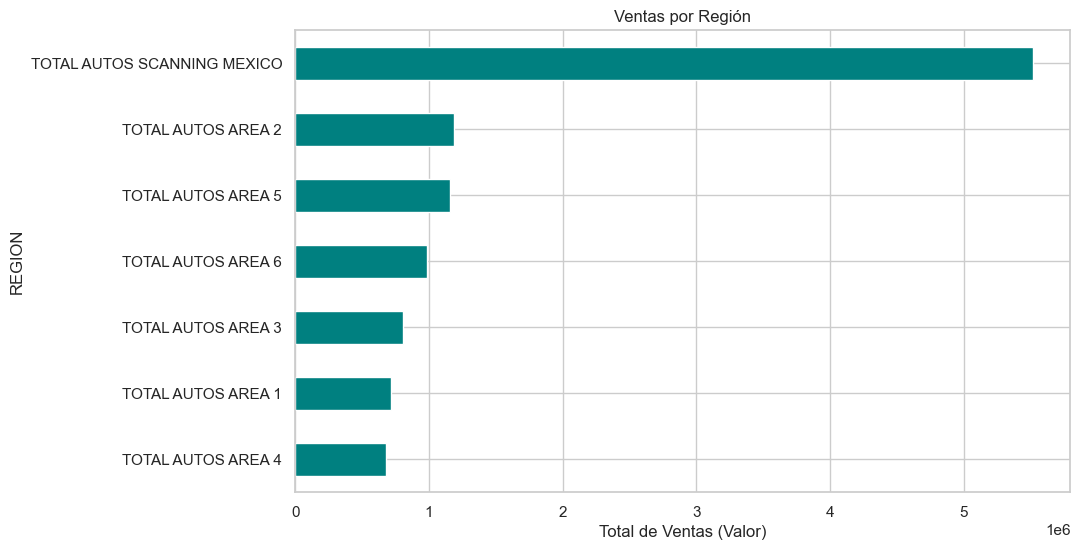

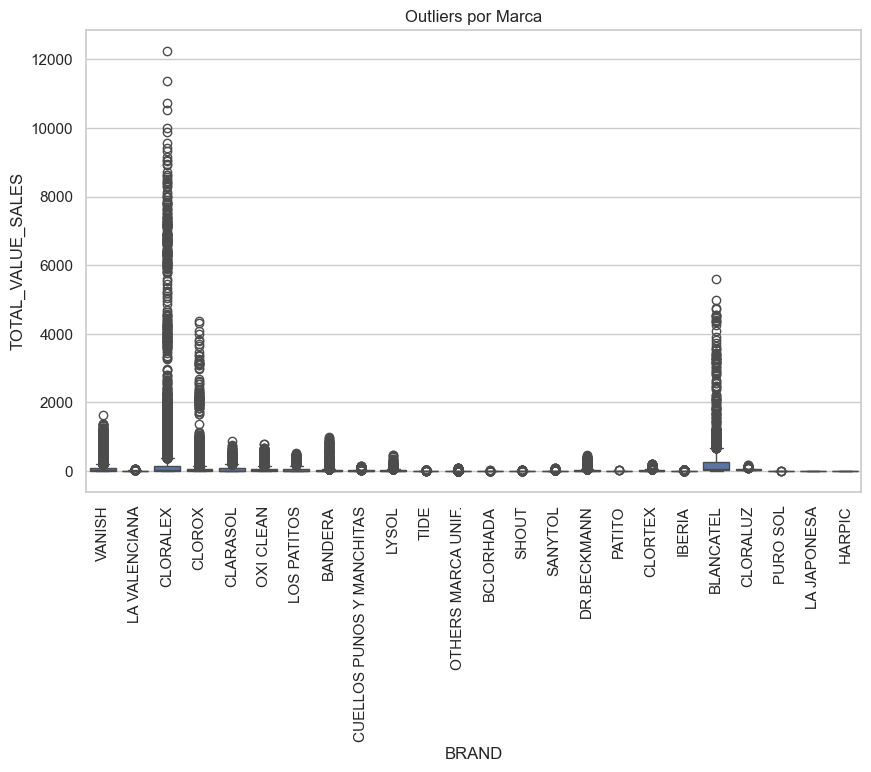

In [19]:
if not pd.api.types.is_datetime64_any_dtype(df["WEEK"]):
    df["WEEK"] = df["WEEK"].astype(str)
    df["WEEK"] = pd.to_datetime(df["WEEK"] + '-1', format='%W-%y-%w', errors="coerce")

#Eliminar fechas no convertibles
df = df.dropna(subset=["WEEK"])

#Tendencia en el tiempo
ventas_por_semana = df.groupby("WEEK")["TOTAL_VALUE_SALES"].sum().reset_index()
sns.lineplot(x="WEEK", y="TOTAL_VALUE_SALES", data=ventas_por_semana)
plt.title("Tendencia de Ventas en el Tiempo")
plt.savefig("tendencia_ventas.png")
plt.show()

#Tendencia por región
ventas_region = df.groupby(["WEEK", "REGION"])["TOTAL_VALUE_SALES"].sum().reset_index()
sns.lineplot(data=ventas_region, x="WEEK", y="TOTAL_VALUE_SALES", hue="REGION")
plt.title("Tendencia por Región")
plt.savefig("tendencia_region.png")
plt.show()

#Relación entre variables
sns.scatterplot(x="TOTAL_UNIT_SALES", y="TOTAL_VALUE_SALES", hue="CATEGORY", data=df)
plt.title("Relación entre Total Unidades Vendidas y Valor Total de Venta")
plt.savefig("scatter_unidades_valor.png")
plt.show()

#Distribución geográfica
ventas_por_region = df.groupby("REGION")["TOTAL_VALUE_SALES"].sum().sort_values()
ventas_por_region.plot(kind="barh", color="teal")
plt.title("Ventas por Región")
plt.xlabel("Total de Ventas (Valor)")
plt.savefig("ventas_por_region.png")
plt.show()

#Outliers
sns.boxplot(x="BRAND", y="TOTAL_VALUE_SALES", data=df)
plt.title("Outliers por Marca")
plt.xticks(rotation=90)
plt.savefig("outliers_marca.png")
plt.show()


In [23]:
#Generar insights automáticos
insights = []

#1.Categorías con mayor y menor ventas respecto a productos
ventas_por_categoria = df.groupby("BRAND")["TOTAL_VALUE_SALES"].sum().sort_values(ascending=False)
categoria_top = ventas_por_categoria.idxmax()
categoria_low = ventas_por_categoria.idxmin()
insights.append(f"El producto con mayores ventas es '{categoria_top}' con un total de {ventas_por_categoria.max():,.2f}.")
insights.append(f"El producto con menores ventas es '{categoria_low}' con un total de {ventas_por_categoria.min():,.2f}.")

#2.Región con mejor rendimiento
ventas_por_region = df.groupby("REGION")["TOTAL_VALUE_SALES"].sum().sort_values(ascending=False)
region_top = ventas_por_region.idxmax()
region_low = ventas_por_region.idxmin()
insights.append(f"La región con mayor rendimiento es '{region_top}' con ventas totales de {ventas_por_region.max():,.2f}.")
insights.append(f"La región con menor rendimiento es '{region_low}' con ventas de {ventas_por_region.min():,.2f}.")

#3.Tendencia general de ventas
ventas_por_semana = df.groupby("WEEK")["TOTAL_VALUE_SALES"].sum()
#Verificacion si hay suficientes puntos de datos para encontrar una tendencia
if len(ventas_por_semana) >= 2:
    if ventas_por_semana.iloc[-1] > ventas_por_semana.iloc[0]:
        tendencia = "creciente"
    else:
        tendencia = "decreciente"
    insights.append(f"La tendencia general de ventas en el tiempo es {tendencia}.")
else:
    insights.append("No hay suficientes datos de ventas por semana para determinar una tendencia.")


#4.Outliers por marca
q1 = df["TOTAL_VALUE_SALES"].quantile(0.25)
q3 = df["TOTAL_VALUE_SALES"].quantile(0.75)
iqr = q3 - q1
outliers = df[df["TOTAL_VALUE_SALES"] > (q3 + 1.5 * iqr)]
#Verifica si hay outliers antes de acceder a los nombres por marca
if not outliers.empty:
    marca_outliers = outliers["BRAND"].value_counts().head(3).index.tolist()
    insights.append(f"Se detectaron outliers en las marcas: {', '.join(marca_outliers)}.")
else:
    insights.append("No se detectaron outliers significativos en las ventas por marca.")


#5.Relación entre unidades y valor
correlacion_uv = df[["TOTAL_UNIT_SALES", "TOTAL_VALUE_SALES"]].corr().iloc[0,1]
insights.append(f"La correlación entre unidades vendidas y valor de ventas es de {correlacion_uv:.2f}, lo que indica una {'fuerte' if abs(correlacion_uv) > 0.7 else 'moderada' if abs(correlacion_uv) > 0.4 else 'débil'} correlación.")

#Guardar insights en archivo
with open("insights_ventas.txt", "w", encoding="utf-8") as f:
    for linea in insights:
        f.write(linea + "\n")

#Mostrar insights en pantalla
for linea in insights:
    print(linea)

El producto con mayores ventas es 'CLORALEX' con un total de 5,393,618.51.
El producto con menores ventas es 'HARPIC' con un total de 0.07.
La región con mayor rendimiento es 'TOTAL AUTOS SCANNING MEXICO' con ventas totales de 5,521,429.32.
La región con menor rendimiento es 'TOTAL AUTOS AREA 4' con ventas de 677,436.00.
La tendencia general de ventas en el tiempo es decreciente.
Se detectaron outliers en las marcas: CLORALEX, VANISH, CLOROX.
La correlación entre unidades vendidas y valor de ventas es de 0.92, lo que indica una fuerte correlación.
